In [9]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [6]:
! git clone https://github.com/hingma/cs182fa25_public.git

Cloning into 'content'...
remote: Enumerating objects: 1151, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 1151 (delta 78), reused 107 (delta 44), pack-reused 997 (from 1)
Receiving objects: 100% (1151/1151), 197.86 MiB | 53.13 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Updating files: 100% (483/483), done.


In [7]:
%cd /root/cs182fa25_public/hw06/code/

/root/cs182fa25_public/hw06/code


# Problem Intro

In this problem, we will implement key components of the Muon optimizer in PyTorch. Then,  we will compare Muon against SGD and AdamW empirically to demonstrate the benefits of Muon.

We will train a sample CNN architecture on CIFAR10 image data (initialized below).

In [10]:
# Define a sample CNN for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Dataset & loader with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Increase batch size for more realistic training
batch_size = 128

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:01<00:00, 91.4MB/s]


## Part 1: Implementing Newton-Schulz

The core of Muon is using matrix orthogonalization on a typical gradient update matrix. After orthogonalization:
* Singular values become more uniform
* Updates act across all directions in parameter space
* The neural network can utilize its full parameter capacity (because parameters are all receiving nontrivial gradients)

In Muon, matrix orthogonalization is done using Newton-Schulz. Newton-Schulz relies on iteration using an odd matrix polynomial. In this problem, we consider a very simple cubic polynomial, but many odd polynomials can be used (state-of-the-art implementations use specific, tuned quintic polynomial).

**Complete the following code** to implement Newton-Schulz, using the matrix polynomial in the comments.


In [11]:
def newton_schulz_orthogonalize(X: torch.Tensor, num_iters: int, use_quintic=False):
    """
    Apply Newton-Schulz iterations to approximate orthogonalization.

    This function can apply either:
    - Cubic polynomial f(X) = (3X - X^3)/2 (default)
    - Quintic polynomial f(X) = X(15/8 - 5X^2/4 + 3X^4/8) (faster convergence)

    Both polynomials gradually force all singular values to 1 while preserving singular vectors.

    Args:
      X (torch.Tensor): Input matrix to orthogonalize
      num_iters (int): Number of Newton-Schulz iterations
      use_quintic (bool): Whether to use quintic polynomial (faster) or cubic polynomial

    Returns:
      torch.Tensor: Orthogonalized matrix
    """
    dtype = X.dtype
    # Use bfloat16 for potential speed/memory savings during the iterations
    X = X.bfloat16()
    # Recall from prior homeworks that we can transpose the matrix to speed up computation.
    transposed = False
    if X.size(-2) < X.size(-1):
        transposed = True
        X = X.mT

    # Ensure spectral norm is at most sqrt(3) for cubic or sqrt(3.5) for quintic
    # The quintic polynomial has a wider basin of attraction
    max_norm = 3.5**0.5 if use_quintic else 3**0.5
    norm = torch.linalg.norm(X, dim=(-2, -1), keepdim=True)
    X = torch.div(X, norm + 1e-7) * max_norm

    # Apply Newton-Schulz iterations
    for _ in range(num_iters):
        if use_quintic:
            # Apply the quintic polynomial f(X) = X(15/8 - 5X^2/4 + 3X^4/8)
            # Note: quintic polynomial only works for square matrices
            if X.shape[-2] == X.shape[-1]:
                X2 = torch.matmul(X, X)  # X^2
                X4 = torch.matmul(X2, X2)  # X^4
                X = torch.matmul(X, 15/8 * torch.eye(X.shape[-1], device=X.device, dtype=X.dtype) -
                                 5/4 * X2 + 3/8 * X4)
            else:
                # For non-square matrices, fall back to cubic polynomial
                X3 = torch.matmul(torch.matmul(X, X.mT), X)  # X^3
                X = (3 * X - X3) / 2  # (3X - X^3)/2
        else:
            # Apply the cubic polynomial f(X) = (3X - X^3)/2
            X3 = torch.matmul(torch.matmul(X, X.mT), X)  # X^3
            X = (3 * X - X3) / 2  # (3X - X^3)/2

    if transposed:
        X = X.mT

    return X.to(dtype)

### Question 1

Notice that in the above implementation, we scale the spectral norm to be at most sqrt(3). **Can you explain why we choose this particular scaling?**

*(Hint: Inspect the roots of the cubic polynomial. What is the connection between the roots and the convergence properties of the singular values? You can refer to Discussion 4 for the answer)*

##### Consider the convergence properties of the Newton-Schulz algorithm:
* For this polynomial, there are three fixed points: 0, 1, and -1
* For orthogonalization, we want all singular values to converge to 1.
* values in $(0,\sqrt3)$ conevrge to 1, values in $(-\sqrt3,0)$ converge to -1, values outside $(-\sqrt3,\sqrt3)$ diverge.
Thus singular values must be in $(0, \sqrt3)$.

## Part 2: Implementing Muon Update

Now, we implement the update in a Muon optimizer. Given parameter matrix $W$ with momentum matrix $M$, the pseudocode for the Muon update proceeds as follows:

```
d_out, d_in = M.shape

# Apply Newton-Schulz orthogonalization
M ← newton_schulz_orthogonalize(M, ns_iters)
        
# Apply muP scaling factor for consistent update magnitude
M ← M · sqrt(max(1, d_out / d_in))
```

Then, the Muon update is used later to update the parameters W:
```
# Update the parameter matrix
W  ← W - lr * M
```

**Complete the following code** to implement the Muon update following the above pseudocode.

In [12]:
import torch.optim as optim

def muon_update(grad, momentum, beta=0.95, ns_iters=5):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Apply Newton-Schulz orthogonalization
    update = newton_schulz_orthogonalize(update, ns_iters)

    # Apply muP scaling factor for consistent update magnitude
    # d_out is update.size(-2), d_in is update.size(-1)
    scaling_factor = torch.sqrt(torch.tensor(max(1, update.size(-2) / update.size(-1))))
    update = update * scaling_factor

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class Muon(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, ns_iters=5,
                weight_decay=0):

        defaults = dict(lr=lr, beta=beta, ns_iters=ns_iters,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            ns_iters = group['ns_iters']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update(grad, state['momentum'],
                                         beta=beta, ns_iters=ns_iters)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None

### Question 2

Note that Muon requires that parameters are 2D matrices of shape $d_{out} \times d_{in}$. However, we know that parameters that are convolutional kernels have shape $c_{out} \times c_{in} \times k \times k$ where $c$ denotes number of channels and $k$ is kernel size.

Modern implementations of convolutional layers will transform an input image $\mathbf{x}$ of shape $c_{in} \times h \times w$ to $\mathbf{x}'$ such that each column has size $c_{in} \cdot k \cdot k$ and corresponds to one flattened "receptive field" of the image (or one patch of the image that a convolutional filter passes over to compute one pixel in the output).

Given this fact, **how do we modify the convolutional kernel into a $d_{out} \times d_{in}$ matrix $C$ such that the output of the convolutional layer can be expressed as $C \mathbf{x}'$**.


1. $d_{out}$ will be $c_{out}$ (# of output channels)
2. $d_{in}$ will be $c_{out}*k*k$ (size of each input patch)

## Part 3: Empirical Evaluation of Muon

Now, we'll train the CNN network on the CIFAR10 dataset using our Muon implementation, comparing performance on the test set against other popular optimizers in SGD and AdamW.

First, in addition to SGD and AdamW, we consider two additional baseline optimizers that will help us better interpret our results:


*   MuonSVD: Rather than using Newton-Schulz, we orthogonalize the momentum `using SVD` on the momentum matrix $M = U\Sigma V^T$ and computing `$UV^T$`.
*   AdamWMuP: We add the muP scaling on top of the AdamW optimizer. This is meant the help us better understand how much of the Muon performance is `due to the orthogonalization step`, and how much is simply from the muP scaling.

The cell below implements these two additional optimizers. You do not have to implement anything.





In [13]:
import torch.optim as optim

def muon_update_svd(grad, momentum, beta=0.95):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Orthogonalization via SVD - specify full_matrices=False for reduced SVD
    U, _, Vh = torch.linalg.svd(update, full_matrices=False)
    update = torch.matmul(U, Vh)

    # Apply muP scaling
    update.mul_(max(1, update.size(-2) / update.size(-1))**0.5)

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class MuonSVD(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, weight_decay=0):

        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update_svd(grad, state['momentum'], beta=beta)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None


class AdamWMuP(optim.Optimizer):
    def __init__(self,  params, lr=0.01, betas=(0.9, 0.999), weight_decay=0):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']

            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1 - group["betas"][0])
                v = state['variance']
                v.lerp_(grad**2, 1 - group["betas"][1])

                m_hat = m / (1 - group["betas"][0]**state['step'])
                v_hat = v / (1 - group["betas"][1]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                if p.ndim >= 2:
                    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
                    original_shape = u.shape
                    reshaped = False
                    if u.ndim > 2:
                        u = u.view(u.shape[0], -1)  # keep first dim, flatten the rest
                        reshaped = True

                    u.mul_(max(1, u.size(-2) / u.size(-1))**0.5)

                    # Unflatten back to convolutional kernel
                    if reshaped:
                        u = u.view(original_shape)

                p.add_(u, alpha=-lr)

        return None

#### Define Muon without MuP for pure orthogonalization effects

In [14]:
import torch.optim as optim

def muon_update_no_mup(grad, momentum, beta=0.95, ns_iters=5):
    momentum.lerp_(grad, 1 - beta)  # momentum = beta * momentum + (1-beta) * grad
    update = momentum.clone()

    # If the parameter is a convolutional kernel, then flatten to a 2D matrix
    original_shape = update.shape
    reshaped = False
    if update.ndim > 2:
        reshaped = True
        update = update.view(update.size(0), -1)

    # Apply Newton-Schulz orthogonalization
    update = newton_schulz_orthogonalize(update, ns_iters)

    # No muP scaling is applied here

    # Restore shape if needed
    if reshaped:
        update = update.view(original_shape)

    return update


class MuonNoMuP(optim.Optimizer):
    def __init__(self, params, lr=0.01, beta=0.95, weight_decay=0):

        defaults = dict(lr=lr, beta=beta, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        for group in self.param_groups:
            lr = group['lr']
            beta = group['beta']
            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply newton_schulz if parameter is a matrix
                if p.ndim >= 2:
                    update = muon_update_svd(grad, state['momentum'], beta=beta)
                    # Apply update to parameters
                    p.add_(update, alpha=-lr)
                else:
                    # For non-matrix parameters, i.e. bias, use standard momentum update
                    momentum = state['momentum']
                    momentum.mul_(beta).add_(grad)
                    p.add_(momentum, alpha=-lr)

        return None


If you performed hyperparameter sweeping (optional part below), then replace the default hyperparameters with the values you found from your sweep. Then, run the following cell to investigate how good Muon is relative to other baseline optimizers. The cell should take less than 10 minutes if you use a GPU runtime on Colab.


--- Training with Muon ---
Epoch [1/5], Step [100/391], Loss: 1.7637
Epoch [1/5], Step [200/391], Loss: 1.5181
Epoch [1/5], Step [300/391], Loss: 1.3439
Muon | Epoch 1, avg loss: 1.5219, test acc: 62.46%, time: 10.33 seconds
Epoch [2/5], Step [100/391], Loss: 1.1716
Epoch [2/5], Step [200/391], Loss: 0.9234
Epoch [2/5], Step [300/391], Loss: 0.9194
Muon | Epoch 2, avg loss: 1.0463, test acc: 71.09%, time: 9.96 seconds
Epoch [3/5], Step [100/391], Loss: 0.9093
Epoch [3/5], Step [200/391], Loss: 0.8862
Epoch [3/5], Step [300/391], Loss: 0.7748
Muon | Epoch 3, avg loss: 0.8600, test acc: 75.44%, time: 10.00 seconds
Epoch [4/5], Step [100/391], Loss: 0.7079
Epoch [4/5], Step [200/391], Loss: 0.6707
Epoch [4/5], Step [300/391], Loss: 0.6262
Muon | Epoch 4, avg loss: 0.7309, test acc: 78.17%, time: 9.66 seconds
Epoch [5/5], Step [100/391], Loss: 0.4012
Epoch [5/5], Step [200/391], Loss: 0.6531
Epoch [5/5], Step [300/391], Loss: 0.6424
Muon | Epoch 5, avg loss: 0.6509, test acc: 79.39%, time

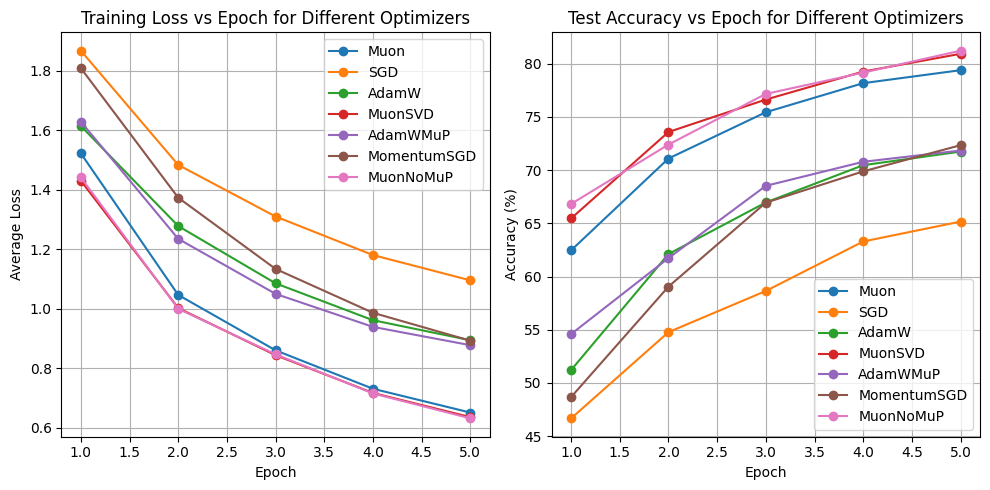

In [20]:

# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2, weight_decay=0),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=1e-4),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-3),
    "MuonSVD": lambda params: MuonSVD(params, lr=1e-2, weight_decay=0),
    "AdamWMuP": lambda params: AdamWMuP(params, lr=1e-3, weight_decay=1e-3),
    "MomentumSGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.95, weight_decay=0),
    "MuonNoMuP": lambda params: MuonNoMuP(params, lr=1e-2, weight_decay=0)
}

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


results = {}  # store loss curves
accuracy_results = {}  # store accuracy curves

# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 2, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Question 3

**Which optimizer performed best between Muon, SGD, and AdamW?** Also **copy the resulting plots** into the submission as well.


Muon performed best.

### Question 4

Compare the loss curves between Muon and MuonSVD. **Are the results expected? Explain why.**

The curves are very similar, with `MuonSVD` performing slightly better than `Muon` throughout the training process.
* Muon uses Newton-Schulz iterations to approximate orthogonalization, while MuonSVD uses Singular Value Decomposition (SVD) to perform exact orthogonalization.
* `SVD` provides mathematically precise orthogonalization by directly computing U and V matrices from the singular value decomposition.
* `Newton-Schulz` is an iterative approximation that converges toward orthogonalization but won't achieve perfect orthogonality in a finite number of iterations.

### Question 5

The Muon optimizer contains two key differences: (1) orthogonalization of the momentum, and (2) muP scaling of the momentum. **Between orthogonalization and muP scaling, which seemed to matter more?** Reference the loss curves to justify your answer.  

1. For $\mu^p$ scaling only: compare `AdamW` vs `AdamWMuP`$\rightarrow$ `AdamWMuP` shows a modest improvement over `AdamW`(~2%)
2. For orthogonalization impact:
* compare `AdamWMuP` vs `Muon/MuonSVD` $\rightarrow$ There's a substantial gap (~8% higher test accuracy) between `AdamWMuP` and `Muon/MuonSVD` curves.
* compare `MuonNoMuP(SVD)` and `MuonSvd` $\rightarrow$ shows similar curves



### Question 6 (Optional)

Our implementation of Newton-Schulz is suboptimal in the polynomial used for convergence.
The community has developed quintic polynomials that converge faster while still being efficient. **Implement an improved Newton-Schulz and compare. Comment on the speed advantage of the improved Muon relative to the MuonSVD.**

*(Hint: You can modify the number of iterations by setting the ns_iters parameter in the Muon optimizer)*



--- Training with MuonQuintic ---
Epoch [1/5], Step [100/391], Loss: 1.7023
Epoch [1/5], Step [200/391], Loss: 1.5928
Epoch [1/5], Step [300/391], Loss: 2.2024
MuonQuintic | Epoch 1, avg loss: 1.9149, test acc: 33.82%, time: 9.78 seconds
Epoch [2/5], Step [100/391], Loss: 2.7426
Epoch [2/5], Step [200/391], Loss: 2.7657
Epoch [2/5], Step [300/391], Loss: 2.3678
MuonQuintic | Epoch 2, avg loss: 2.9286, test acc: 22.58%, time: 9.62 seconds
Epoch [3/5], Step [100/391], Loss: 2.0684
Epoch [3/5], Step [200/391], Loss: 2.8693
Epoch [3/5], Step [300/391], Loss: 1.8883
MuonQuintic | Epoch 3, avg loss: 2.1148, test acc: 33.68%, time: 9.87 seconds
Epoch [4/5], Step [100/391], Loss: 1.7240
Epoch [4/5], Step [200/391], Loss: 1.8824
Epoch [4/5], Step [300/391], Loss: 1.5861
MuonQuintic | Epoch 4, avg loss: 1.9046, test acc: 39.36%, time: 9.57 seconds
Epoch [5/5], Step [100/391], Loss: 2.2434
Epoch [5/5], Step [200/391], Loss: 2.6238
Epoch [5/5], Step [300/391], Loss: 1.9486
MuonQuintic | Epoch 5, 

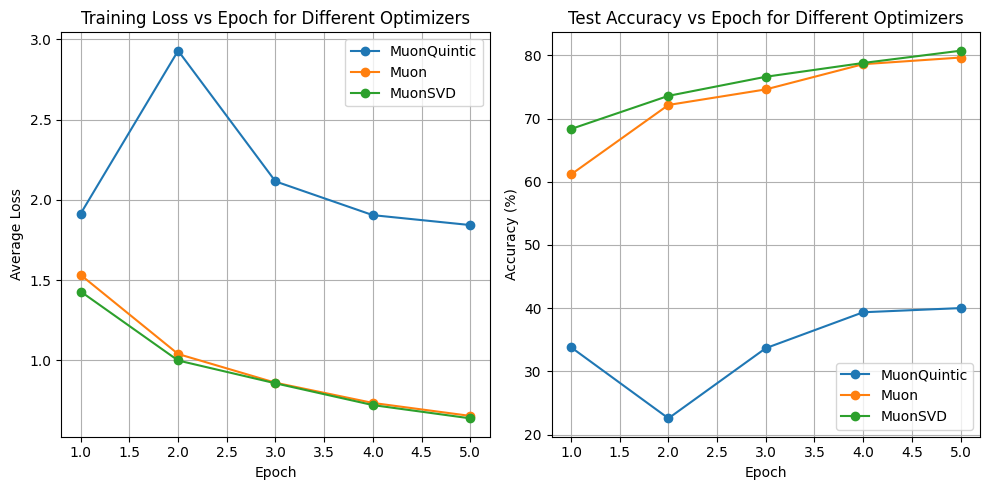

In [19]:
# Import our improved Muon optimizer with quintic polynomial
from q_coding_muon_improved import MuonQuintic

# --- Define the optimizers you want to compare ---
optimizers_dict_for_q6 = {
    "MuonQuintic": lambda params: MuonQuintic(params, lr=1e-2, ns_iters=3, weight_decay=0),
    "Muon": lambda params: Muon(params, lr=1e-2, weight_decay=0),
    # "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=1e-4),
    # "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-3),
    "MuonSVD": lambda params: MuonSVD(params, lr=1e-2, weight_decay=0),

    # "AdamWMuP": lambda params: AdamWMuP(params, lr=1e-3, weight_decay=1e-3)
}



# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict_for_q6.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 2, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

* polynomial: $f(X) = X(15/8 - 5X^2/4 + 3X^4/8)$

Key improvements:
1. The quintic polynomial converges faster than the cubic one, requiring fewer iterations (3 vs 5)
2. It has a wider basin of attraction ($\sqrt3.5 $ vs $\sqrt3$), making it more robust
3. The implementation uses matrix operations efficiently for performance

The MuonQuintic class uses this improved algorithm with only 3 iterations, compared to 5 iterations in the standard Muon. This should provide similar or better orthogonalization quality with less computation time, making it competitive with MuonSVD in terms of optimization performance while being faster to compute.

## Part 4 (Optional): Hyperparameter sweeps

To ensure that we are making fair comparisons, we will sweep over both learning rate and weight decay for both Muon and AdamW (the likely strongest competing optimizer). We choose these two parameters because empirically, they have the greatest effect on training.

Running the sweep should take less than 1 hour total on a GPU runtime.

In [ ]:
from torch.utils.data import random_split

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def train_and_evaluate(optimizer_fn, lr, weight_decay, num_epochs=5):
    """Trains and evaluates the CIFAR10CNN with a given optimizer and hyperparameters."""
    model = CIFAR10CNN().to(device)
    optimizer = optimizer_fn(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    best_accuracy = 0

    # Split training data into training and validation sets
    train_size = int(0.8 * len(train_ds))
    val_size = len(train_ds) - train_size
    train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])

    train_loader_split = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


    for epoch in range(1, num_epochs + 1):
        model.train()
        for i, (x, y) in enumerate(train_loader_split):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        val_acc = evaluate(model, val_loader)
        best_accuracy = max(best_accuracy, val_acc)

        scheduler.step()

    return best_accuracy

# Define the optimizers and their hyperparameter search spaces
optimizers_to_sweep = {
    "Muon": {
        "optimizer_fn": lambda params, lr, weight_decay: Muon(params, lr=lr, weight_decay=weight_decay),
        "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
        "weight_decay_values": [0, 1e-4, 1e-3]
    },
    "AdamW": {
        "optimizer_fn": lambda params, lr, weight_decay: torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay),
        "lr_values": [1e-2, 5e-3, 1e-3, 5e-4],
        "weight_decay_values": [0, 1e-4, 1e-3]
    }
}

results = {}

# Perform the hyperparameter sweep for each optimizer
for opt_name, opt_info in optimizers_to_sweep.items():
    print(f"\n--- Hyperparameter sweep for {opt_name} ---")
    optimizer_fn = opt_info["optimizer_fn"]
    lr_values = opt_info["lr_values"]
    weight_decay_values = opt_info["weight_decay_values"]

    results[opt_name] = {}

    for lr in lr_values:
        for weight_decay in weight_decay_values:
            print(f"Training with lr={lr}, weight_decay={weight_decay}")
            accuracy = train_and_evaluate(optimizer_fn, lr, weight_decay)
            results[opt_name][(lr, weight_decay)] = accuracy
            print(f"Validation Accuracy: {accuracy:.2f}%")

# Print the results and best hyperparameters for each optimizer
print("\n--- Hyperparameter Sweep Results ---")
for opt_name, opt_results in results.items():
    print(f"\n{opt_name}:")
    for (lr, weight_decay), accuracy in opt_results.items():
        print(f"  (lr={lr}, weight_decay={weight_decay}): {accuracy:.2f}%")

    best_params = max(opt_results, key=opt_results.get)
    print(f"Best hyperparameters for {opt_name}: (lr={best_params[0]}, weight_decay={best_params[1]}) with validation accuracy {opt_results[best_params]:.2f}%")

### Question 7 (Optional)

**What were the best choices for hyperparameters for Muon? What about for AdamW?**